# Importing Libraries

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.core import Dense, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Reading the dataset

In [2]:
df = pd.read_csv('Consumer_Complaints.csv')

C:\Users\mayan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Descriptive Analysis

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/09/2015,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company chooses not to provide a public response,Experian Information Solutions Inc.,NJ,08872,NaN,Consent not provided,Web,08/09/2015,Closed with non-monetary relief,Yes,No,1509954
1,01/29/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",NY,10801,NaN,Consent not provided,Web,01/30/2019,Closed with non-monetary relief,Yes,NaN,3136759
2,08/19/2015,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,Company chooses not to provide a public response,WELLS FARGO & COMPANY,CA,94526,NaN,Consent not provided,Web,08/19/2015,Closed with explanation,Yes,No,1527601
3,03/04/2016,Credit card,NaN,Billing disputes,NaN,I am dissatisfied with the current outcome of ...,NaN,DISCOVER BANK,NV,891XX,NaN,Consent provided,Web,03/04/2016,Closed with explanation,Yes,Yes,1816726
4,03/18/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",PA,175XX,NaN,NaN,Referral,03/19/2013,Closed with explanation,Yes,No,358304


In [4]:
df.shape

(1451647, 18)

1451647 rows<br>
18 columns

In [5]:
df.dtypes

Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                     int64
dtype: object

In [6]:
states =  pd.crosstab(index=df["State"],  # Make a crosstab
                        columns="count")      # Name the count column
print(states)

col_0                                  count
State                                       
AA                                        25
AE                                       532
AK                                      1511
AL                                     17061
AP                                       384
AR                                      7057
AS                                        27
AZ                                     30317
CA                                    196519
CO                                     22648
CT                                     15848
DC                                      7695
DE                                      6848
FL                                    148032
FM                                       115
GA                                     77227
GU                                       201
HI                                      4423
IA                                      5564
ID                                      4276
IL        

# Exploring the data

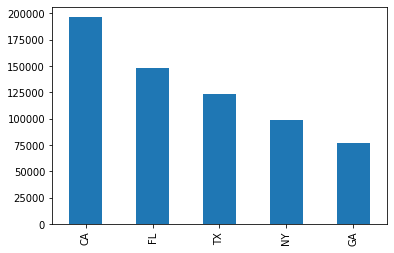

In [7]:
freq_state = df['State'].value_counts()
top_five = freq_state.head(5)
top_five.plot.bar(x = 'State')

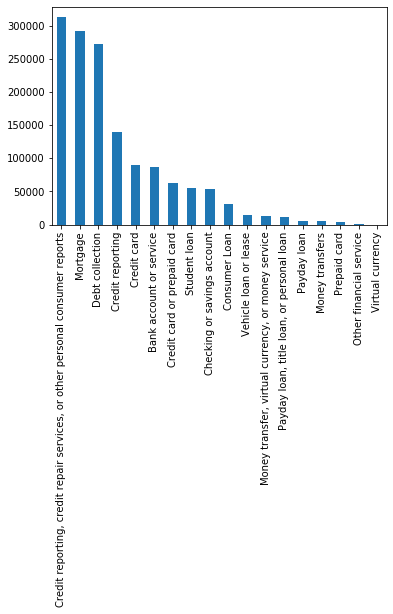

In [8]:
freq_prod = df['Product'].value_counts()
freq_prod.plot.bar(x = 'Product')

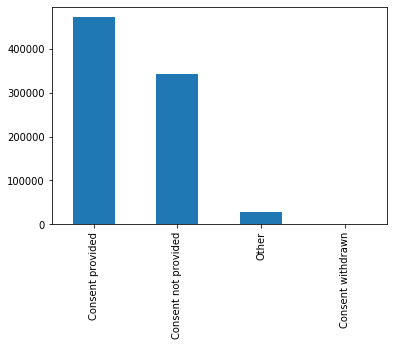

In [9]:
freq_cons = df['Consumer consent provided?'].value_counts()
freq_cons.plot.bar(x = 'Consumer consent provided?')

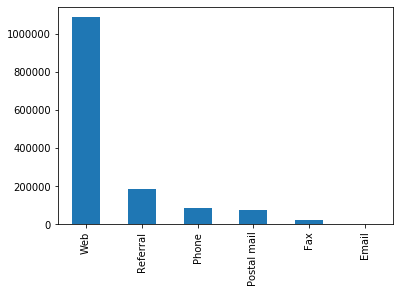

In [10]:
freq_sub = df['Submitted via'].value_counts()
freq_sub.plot.bar(x = 'Submitted via')

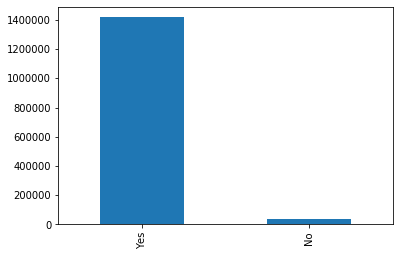

In [11]:
freq_timely = df['Timely response?'].value_counts()
freq_timely.plot.bar(x = 'Timely response?')



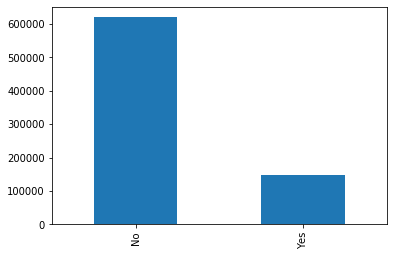

In [12]:
freq_dis = df['Consumer disputed?'].value_counts()
freq_dis.plot.bar(x = 'Consumer disputed?')

Visualising thr NA values

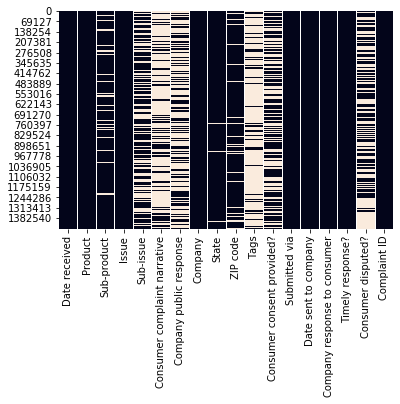

In [13]:
sns.heatmap(df.isnull(), cbar=False)

# Converting string format date data into date format data

In [14]:
date = []
date_str = df['Date received']# The date - 29 Dec 2017
format_str = '%m/%d/%Y' # The format
for i in range(0,len(date_str)):
     date.append( datetime.datetime.strptime(date_str[i], format_str))


In [15]:
df['Date received'] = date

In [16]:
date_sen = []
date_str = df['Date sent to company']# The date - 29 Dec 2017
format_str = '%m/%d/%Y' # The format
for i in range(0,len(date_str)):
     date_sen.append( datetime.datetime.strptime(date_str[i], format_str))


In [17]:
df['Date sent to company'] = date_sen

In [18]:
df.dtypes

Date received                   datetime64[ns]
Product                                 object
Sub-product                             object
Issue                                   object
Sub-issue                               object
Consumer complaint narrative            object
Company public response                 object
Company                                 object
State                                   object
ZIP code                                object
Tags                                    object
Consumer consent provided?              object
Submitted via                           object
Date sent to company            datetime64[ns]
Company response to consumer            object
Timely response?                        object
Consumer disputed?                      object
Complaint ID                             int64
dtype: object

In [19]:
df['Date sent to company'][1]

Timestamp('2019-01-30 00:00:00')

In [20]:
df['Date received'][1]

Timestamp('2019-01-29 00:00:00')

In [21]:
complain_timing = []
z = len(df['Date received'])
for i in range(0,z):
    if df['Date sent to company'][i] == df['Date received'][i]:
        complain_timing.append('Same day')
    elif df['Date sent to company'][i] > df['Date received'][i]:
        complain_timing.append('Next day')
    elif df['Date sent to company'][i] < df['Date received'][i]:
        complain_timing.append('Error')

In [22]:
df['complain_timing'] = complain_timing 

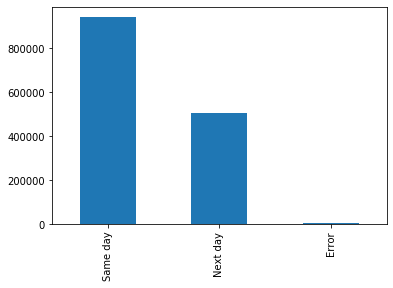

In [23]:
freq_dis = df['complain_timing'].value_counts()
freq_dis.plot.bar(x = 'complain_timing')

#  Data for creating the model

In [24]:
df1 = df[['Consumer complaint narrative', 'Product']]

In [25]:
df1.head()

,Consumer complaint narrative,Product
0,NaN,Credit reporting
1,NaN,"Credit reporting, credit repair services, or o..."
2,NaN,Mortgage
3,I am dissatisfied with the current outcome of ...,Credit card
4,NaN,Mortgage


# Dropping the NA values

In [26]:
df1 = df1.dropna()

In [27]:
df1.head()

,Consumer complaint narrative,Product
3,I am dissatisfied with the current outcome of ...,Credit card
7,On XX/XX/18 an item showed up on my credit rep...,"Credit reporting, credit repair services, or o..."
8,Saw on my credit report that there is a collec...,Debt collection
9,Capital one auto finacing XX/XX/2018 unknown i...,"Credit reporting, credit repair services, or o..."
11,I own a small trucking company. One of my truc...,Credit card or prepaid card


# Shape of new data frame

In [28]:
df1.shape

(470924, 2)

In [29]:
df1['Consumer complaint narrative'][7]

'On XX/XX/18 an item showed up on my credit report that had previously been removed under a different collection agency based on a burden of proof that the debt even existed which it did not. It would appear that this debt was then sold to XXXX XXXX XXXX. These practices are highly illegal. I demand that this be removed from my report immediately.'

In [30]:
df1.Product.unique()

array(['Credit card',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Credit card or prepaid card', 'Mortgage',
       'Bank account or service', 'Credit reporting', 'Student loan',
       'Checking or savings account', 'Vehicle loan or lease',
       'Consumer Loan',
       'Money transfer, virtual currency, or money service',
       'Money transfers', 'Payday loan',
       'Payday loan, title loan, or personal loan',
       'Other financial service', 'Prepaid card', 'Virtual currency'],
      dtype=object)

In [31]:
df1.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    134817
Debt collection                                                                 102931
Mortgage                                                                         59911
Credit reporting                                                                 31588
Credit card or prepaid card                                                      29925
Student loan                                                                     24480
Credit card                                                                      18838
Checking or savings account                                                      17968
Bank account or service                                                          14885
Consumer Loan                                                                     9473
Vehicle loan or lease                                                             7739
Money transfer, virtual currency, or money 

# Labelling the product

In [32]:
df1['Product'] = df1.Product.replace('Credit reporting, credit repair services, or other personal consumer reports','Credit Department')
df1['Product'] = df1.Product.replace('Credit reporting','Credit Department')
df1['Product'] = df1.Product.replace('Credit card or prepaid card', 'Credit Department')
df1['Product'] = df1.Product.replace('Credit card', 'Credit Department')

In [33]:
df1['Product'] = df1.Product.replace('Student loan', 'Loan Department')
df1['Product'] = df1.Product.replace('Consumer Loan', 'Loan Department')
df1['Product'] = df1.Product.replace('Vehicle loan or lease', 'Loan Department')
df1['Product'] = df1.Product.replace('Payday loan, title loan, or personal loan', 'Loan Department')
df1['Product'] = df1.Product.replace('Payday loan', 'Loan Department')

In [34]:
df1['Product'] = df1.Product.replace('Debt collection', 'Debit Department')

In [35]:
df1.Product.value_counts()

Credit Department                                     215168
Debit Department                                      102931
Mortgage                                               59911
Loan Department                                        49425
Checking or savings account                            17968
Bank account or service                                14885
Money transfer, virtual currency, or money service      7381
Money transfers                                         1497
Prepaid card                                            1450
Other financial service                                  292
Virtual currency                                          16
Name: Product, dtype: int64

In [36]:
df1['Product'] = df1.Product.replace('Money transfer, virtual currency, or money service', 'Currency related')
df1['Product'] = df1.Product.replace('Money transfers', 'Currency related')
df1['Product'] = df1.Product.replace('Virtual currency', 'Currency related')

In [37]:
df1['Product'] = df1.Product.replace('Checking or savings account', 'Accounts Department')
df1['Product'] = df1.Product.replace('Bank account or service', 'Accounts Department')

In [38]:
df1['Product'] = df1.Product.replace('Mortgage', 'Mortgage  Department')

In [39]:
df1.Product.value_counts()

Credit Department          215168
Debit Department           102931
Mortgage  Department        59911
Loan Department             49425
Accounts Department         32853
Currency related             8894
Prepaid card                 1450
Other financial service       292
Name: Product, dtype: int64

In [40]:
a = ['Other financial service', 'Prepaid card']
df1 = df1[~df1['Product'].isin(a)]

In [41]:
df1.shape

(469182, 2)

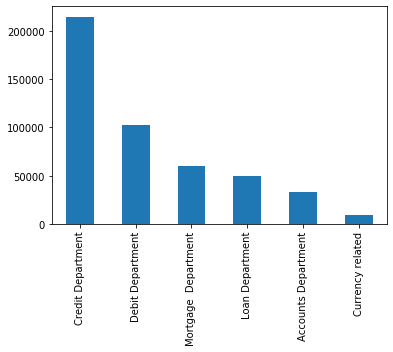

In [50]:
freq_cons = df1['Product'].value_counts()
freq_cons.plot.bar(x = 'Product')

# Text Preprocessing

In [43]:
df1 = df1.reset_index(drop=True)
space = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')
stopWords = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = space.sub(' ', text) 
    text = symbols.sub('', text) 
    text = ' '.join(word for word in text.split() if word not in stopWords) # remove stopwors from text
    return text
df1['Consumer complaint narrative'] = df1['Consumer complaint narrative'].apply(clean_text)
df1['Consumer complaint narrative'] = df1['Consumer complaint narrative'].str.replace('\d+', '')


# Model Building

In [44]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',lower = True)
tokenizer.fit_on_texts(df1['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 169277 unique tokens.


In [45]:
X = tokenizer.texts_to_sequences(df1['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (469182, 250)


In [46]:
Y = pd.get_dummies(df1['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (469182, 6)


In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(422263, 250) (422263, 6)
(46919, 250) (46919, 6)


In [48]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

C:\Users\mayan\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 380036 samples, validate on 42227 samples
Epoch 1/5
380036/380036 [==============================] - 5279s 14ms/step - loss: 0.6072 - accuracy: 0.7947 - val_loss: 0.4305 - val_accuracy: 0.8529
Epoch 2/5
380036/380036 [==============================] - 3045s 8ms/step - loss: 0.3944 - accuracy: 0.8642 - val_loss: 0.3744 - val_accuracy: 0.8706
Epoch 3/5
380036/380036 [==============================] - 2843s 7ms/step - loss: 0.3440 - accuracy: 0.8800 - val_loss: 0.3554 - val_accuracy: 0.8765
Epoch 4/5
380036/380036 [==============================] - 2840s 7ms/step - loss: 0.3118 - accuracy: 0.8917 - val_loss: 0.3550 - val_accuracy: 0.8770
Epoch 5/5
380036/380036 [==============================] - 4199s 11ms/step - loss: 0.2848 - accuracy: 0.9011 - val_loss: 0.3648 - val_accuracy: 0.8762


In [49]:
accuracy = model.evaluate(X_test,Y_test)
print("Average accuracy :", accuracy[1])
print("Loss :", accuracy[0])
#print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

46919/46919 [==============================] - 131s 3ms/step
Average accuracy : 0.8770434260368347
Loss : 0.35726693552072764
